# Proyección de pérdidas cancelación anticipada

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
datos = pd.read_csv("../db/cancelacion_anticipada.csv", sep=";")

In [3]:
datos.columns

Index(['FEC_SALDO', 'NO_CREDITO', 'CODIGO_CLIENTE', 'ESTADO_SALDO',
       'FECHA_APERTURA', 'FECHA_CANCELACION', 'FECHA_VENCIMIENTO', 'TASA',
       'ES_CANCELACION', 'ES_RECREDITO', 'CANCELACION', 'CODIGO_PATRONO',
       'ES_DESERCION', 'ES_CLIENTE_PRODUCTOS_VIGENTES', 'CON_CREDITOS_ACTIVOS',
       'TIPO_CANCELACION', 'TIPO_CREDITO', 'TIPO_CLIENTE', 'TIPO_EJECUTIVO',
       'CANTIDAD_MESES_ANTIGUEDAD_CLIENTE', 'CANTIDAD_CREDITOS_ACTIVOS',
       'CANTIDAD_MESES_A_PAGAR', 'CANTIDAD_MESES_TRANSCURRIDOS',
       'CANTIDAD_MESES_PENDIENTES', 'CANCELACION_TOTAL', 'MONTO_DESEMBOLSADO',
       'ABONO_CANCELACION_ANTICIPADA', 'CODIGO_PRODUCTO', 'DxNOMBRE'],
      dtype='object')

In [4]:
datos.head(2)

,FEC_SALDO,NO_CREDITO,CODIGO_CLIENTE,ESTADO_SALDO,FECHA_APERTURA,FECHA_CANCELACION,FECHA_VENCIMIENTO,TASA,ES_CANCELACION,ES_RECREDITO,...,CANTIDAD_MESES_ANTIGUEDAD_CLIENTE,CANTIDAD_CREDITOS_ACTIVOS,CANTIDAD_MESES_A_PAGAR,CANTIDAD_MESES_TRANSCURRIDOS,CANTIDAD_MESES_PENDIENTES,CANCELACION_TOTAL,MONTO_DESEMBOLSADO,ABONO_CANCELACION_ANTICIPADA,CODIGO_PRODUCTO,DxNOMBRE
0,2022-12-31,11305645134,905150737,C,2013-05-08,2022-12-01,2023-05-31,23.0,SI,SI,...,243,0,120,115,5,9494.77,70000.0,0.00,PR_50,Estado (Pasivas)
1,2022-07-31,11307946389,2063596683,C,2013-07-16,2022-07-29,2023-07-31,21.0,SI,SI,...,217,0,120,108,12,7973.03,25000.0,222.92,PR_50,Pagos por Cajaremesa - Cobro Juridico


In [5]:
datos["NO_CREDITO"].value_counts()

NO_CREDITO
11511647229    6
12102183426    6
12106659168    4
12108912238    4
12203294039    4
              ..
12107835321    1
12010253353    1
11903400442    1
11707353238    1
12303447337    1
Name: count, Length: 37339, dtype: int64

In [6]:
print(len(datos))
datos = datos.drop_duplicates()
print(len(datos))

41681
37339


In [7]:
# seleccionar columnas útiles para el modelo
datos_sarima = datos[["NO_CREDITO", "FECHA_CANCELACION", "TASA", "CANCELACION_TOTAL",
                      "MONTO_DESEMBOLSADO"]]

datos_sarima.head(2)

,NO_CREDITO,FECHA_CANCELACION,TASA,CANCELACION_TOTAL,MONTO_DESEMBOLSADO
0,11305645134,2022-12-01,23.0,9494.77,70000.0
1,11307946389,2022-07-29,21.0,7973.03,25000.0


In [8]:
# como no repetimos mes en la muestra, podemos sacar solo el mes
datos_sarima["FECHA_CANCELACION"] = pd.to_datetime(datos_sarima["FECHA_CANCELACION"])
datos_sarima["MES"] = datos_sarima["FECHA_CANCELACION"].dt.month

def poner_fecha(x):
    if x >= 7:
        return "01/" + str(x) + "/2023"
    elif x < 7:
        return "01/" + str(x) + "/2024"
datos_sarima["FECHA"] = "01" + datos_sarima["MES"].astype(str) + ""

datos_sarima["FECHA"] = datos_sarima.apply(lambda x: poner_fecha(x["MES"]), axis=1)
datos["FECHA"] = pd.to_datetime(datos_sarima["FECHA"], format="%d/%m/%Y")

In [9]:
datos_sarima.head(3)

,NO_CREDITO,FECHA_CANCELACION,TASA,CANCELACION_TOTAL,MONTO_DESEMBOLSADO,MES,FECHA
0,11305645134,2022-12-01,23.0,9494.77,70000.0,12,01/12/2023
1,11307946389,2022-07-29,21.0,7973.03,25000.0,7,01/7/2023
2,11308044460,2022-11-03,21.0,15876.50,80000.0,11,01/11/2023


In [10]:
# agrupar por dia, sacar tpp por dia y monto total cancelado por dia
def sacar_tpp(monto, tasa):
    return sum(monto * tasa) / sum(monto)

datos_sarima_agrupado = datos_sarima.groupby(by="FECHA").agg(MONTO_BRUTO=("MONTO_DESEMBOLSADO", "sum"),
                                                                         MONTO_CANCELADO=("CANCELACION_TOTAL", "sum"))
datos_sarima_agrupado["TPP GRUPO"] = datos_sarima.groupby(by="FECHA").apply(lambda x: sacar_tpp(x["MONTO_DESEMBOLSADO"], x["TASA"]))
datos_sarima_agrupado.columns = ["MONTO_BRUTO", "MONTO_CANCELADO", "TPP GRUPO"]
datos_sarima_agrupado.index = pd.to_datetime(datos_sarima_agrupado.index, dayfirst=True)
datos_sarima_agrupado.index = pd.to_datetime(datos_sarima_agrupado.index)
datos_sarima_agrupado = datos_sarima_agrupado.sort_index()
datos_sarima_agrupado.head(2)

,MONTO_BRUTO,MONTO_CANCELADO,TPP GRUPO
FECHA,,,
2023-07-01,2.500788e+08,1.726066e+08,18.353925
2023-08-01,2.738171e+08,1.849539e+08,18.426284


In [11]:
datos_sarima_agrupado.describe()

,MONTO_BRUTO,MONTO_CANCELADO,TPP GRUPO
count,1.200000e+01,1.200000e+01,12.000000
mean,2.241711e+08,1.538099e+08,18.375053
std,7.008739e+07,4.864092e+07,0.326256
min,1.057037e+08,7.213591e+07,17.729083
25%,1.940191e+08,1.286711e+08,18.146371
50%,2.526391e+08,1.748092e+08,18.390105
75%,2.704348e+08,1.851679e+08,18.592949
max,3.011736e+08,2.073144e+08,18.923541


In [12]:
datos_sarima_agrupado.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12 entries, 2023-07-01 to 2024-06-01
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MONTO_BRUTO      12 non-null     float64
 1   MONTO_CANCELADO  12 non-null     float64
 2   TPP GRUPO        12 non-null     float64
dtypes: float64(3)
memory usage: 384.0 bytes


## Correr modelo

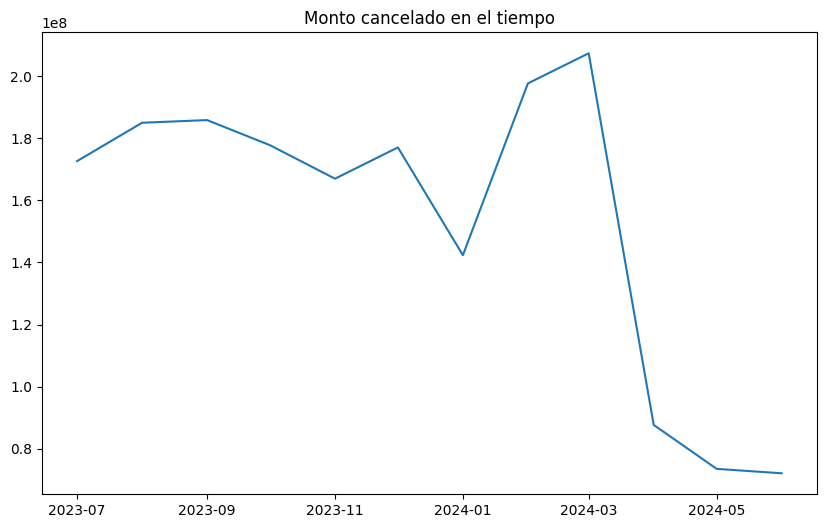

In [13]:
plt.figure(figsize=(10,6))
plt.plot(datos_sarima_agrupado.index, datos_sarima_agrupado["MONTO_CANCELADO"], label="MONTO_CANCELADO")
plt.title("Monto cancelado en el tiempo")
plt.show()

In [56]:
# separar en entrenamiento y testeo
entrenamiento, testeo = train_test_split(datos_sarima_agrupado, test_size=0.2, random_state=42)
entrenamiento.sort_index(inplace=True)
testeo.sort_index(inplace=True)

In [57]:
# hallar parámetros sarima
import itertools
p = q = range(0,1)
d = range(0,1)
pdq = list(itertools.product(p, d, q))
estacional_pdq = [(x[0], x[1], x[2], 2) for x in pdq]


best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

for param in pdq:
    for param_seasonal in estacional_pdq:
        try:
            mod = SARIMAX(entrenamiento['MONTO_CANCELADO'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except Exception as e:
            print(f"Error with parameters {param} & {param_seasonal}: {e}")
            continue

print(f'Mejor SARIMAX orden: {best_pdq}')
print(f'Mejor orden estacional: {best_seasonal_pdq}')

Mejor SARIMAX orden: (0, 0, 0)
Mejor orden estacional: (0, 0, 0, 2)


In [63]:
modelo = SARIMAX(entrenamiento["MONTO_CANCELADO"], order=best_pdq,
                 seasonal_order=(0,1,1,2), enforce_stationarity=False,
                 enforce_invertibility=False)
modelo_fitted = modelo.fit(disp=False)

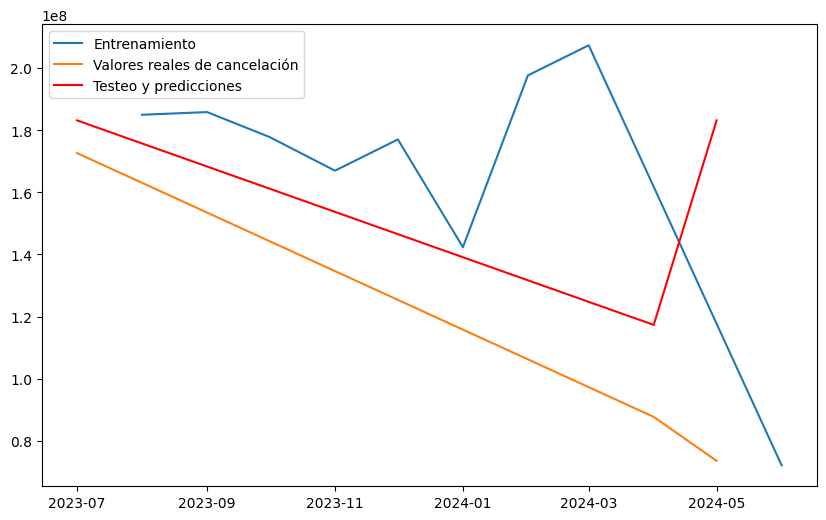

In [64]:
predicciones = modelo_fitted.forecast(steps=len(testeo))

# graficar predicciones y reales
plt.figure(figsize=(10,6))
plt.plot(entrenamiento.index, entrenamiento["MONTO_CANCELADO"], label="Entrenamiento")
plt.plot(testeo.index, testeo["MONTO_CANCELADO"], label="Valores reales de cancelación")
plt.plot(testeo.index, predicciones, label="Testeo y predicciones", color="red")
plt.legend()
plt.show()


In [65]:
meses_a_predecir = 9
modelo_predictivo = SARIMAX(datos_sarima_agrupado["MONTO_CANCELADO"], order=best_pdq,
                            seasonal_order=(1,1,1,2), enforce_invertibility=False,
                            enforce_stationarity=False)

modelo_predictivo_fitted = modelo_predictivo.fit(disp=False)
predicciones_modelo = modelo_predictivo_fitted.get_forecast(steps=meses_a_predecir)
retrofit = pd.DataFrame.from_dict({"Fechas": ["30/04/2024", "31/05/2024", "30/06/2024",
                                              "31/07/2024", "30/08/2024", "30/09/2024",
                                              "31/10/2024", "30/11/2024", "31/12/2024"]})
retrofit["MONTO CANCELADO ESTIMADO"] = list(predicciones_modelo.predicted_mean)

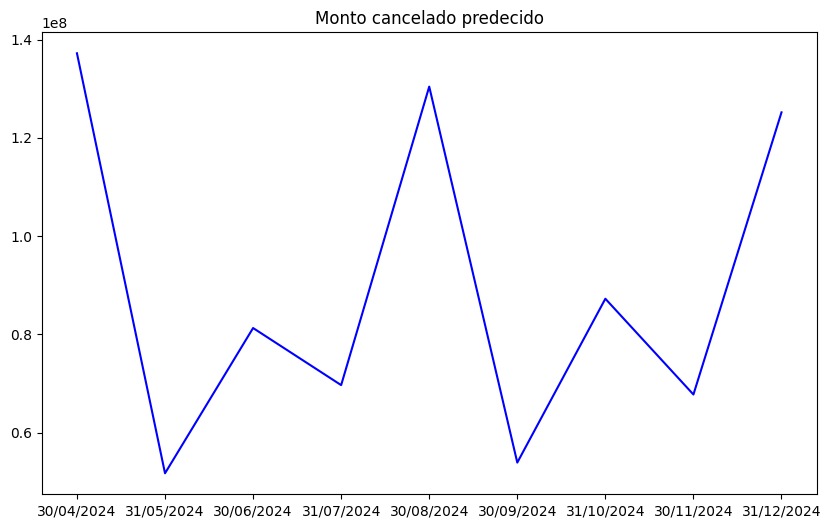

In [66]:
plt.figure(figsize=(10,6))
plt.plot(retrofit["Fechas"], retrofit["MONTO CANCELADO ESTIMADO"], color="blue")
plt.title("Monto cancelado predecido")
plt.show()

In [67]:
retrofit["TPP PROMEDIO"] = 0.1889
retrofit["MARGEN CANCELADO"] = retrofit["TPP PROMEDIO"] * retrofit["MONTO CANCELADO ESTIMADO"]


In [68]:
sum(retrofit["MONTO CANCELADO ESTIMADO"]) / 10**6

804.3477616921717